In [1]:
import os
import copy
import pickle
import sympy
import functools
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_injection import MissingValueError, SamplingError, Injector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mutual_info_score, auc, roc_curve, roc_auc_score, f1_score
from scipy.optimize import minimize as scipy_min
from scipy.spatial import ConvexHull
from scipy.optimize import minimize, Bounds, linprog
from sympy import Symbol as sb
from sympy import lambdify
from tqdm.notebook import trange,tqdm
from IPython.display import display,clear_output
from random import choice
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

class style():
    RED = '\033[31m'
    GREEN = '\033[32m'
    BLUE = '\033[34m'
    RESET = '\033[0m'

np.random.seed(1)

# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_ins_cleaned():
    # fetch dataset
    auto_mpg = pd.read_csv('insurance.csv').drop('sex', axis=1).drop('smoker', axis=1).drop('region', axis=1).replace('?', np.nan)
    features = ['age', 'bmi', 'children']
    X = auto_mpg[features].astype(float)
    y = auto_mpg['charges']
    
    # assumed gt imputation
    imputer = KNNImputer(n_neighbors=10)
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train = copy.deepcopy(X_train).reset_index(drop=True)
    X_test = copy.deepcopy(X_test).reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_ins_cleaned()

In [4]:
#Useful functions
symbol_id = -1
def create_symbol(suffix=''):
    global symbol_id
    symbol_id += 1
    name = f'e{symbol_id}_{suffix}' if suffix else f'e{symbol_id}'
    return sympy.Symbol(name=name)


scaler_symbols = set([sb(f'k{i}') for i in range(X_train.shape[1]+1)])
linearization_dict = dict()
reverse_linearization_dict = dict()

def inject_ranges(X, y, uncertain_attr, uncertain_num, uncertain_radius_pct=None, uncertain_radius=None, seed=42):
    global symbol_id
    symbol_id = -1
    
    X_extended = np.append(np.ones((len(X), 1)), X, axis=1)
    ss = StandardScaler()
    X_extended[:, 1:] = ss.fit_transform(X_extended[:, 1:])
    X_extended_symb = sympy.Matrix(X_extended)
    
    if not(uncertain_attr=='y'):
        uncertain_attr_idx = X.columns.to_list().index(uncertain_attr) + 1
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(np.max(X_extended[:, uncertain_attr_idx])-\
                                                     np.min(X_extended[:, uncertain_attr_idx]))
    else:
        if not(uncertain_radius):
            uncertain_radius = uncertain_radius_pct*(y_train.max()-y_train.min())[0]
    
    np.random.seed(seed)
    uncertain_indices = np.random.choice(range(len(y)), uncertain_num, replace=False)
    y_symb = sympy.Matrix(y)
    symbols_in_data = set()
    for uncertain_idx in uncertain_indices:
        new_symb = create_symbol()
        symbols_in_data.add(new_symb)
        if uncertain_attr=='y':
            y_symb[uncertain_idx] = y_symb[uncertain_idx] + uncertain_radius*new_symb
        else:
            X_extended_symb[uncertain_idx, uncertain_attr_idx] = X_extended_symb[uncertain_idx, uncertain_attr_idx] + uncertain_radius*new_symb
    return X_extended_symb, y_symb, symbols_in_data, ss

# if interval=True, use interval arithmetic, otherwise use zonotopes
def compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, robustness_radius,
                                         uncertain_num, uncertain_radius=None, 
                                         lr=0.1, seed=42, interval=True):
    X, y, symbols_in_data, ss = inject_ranges(X=X_train, y=y_train, uncertain_attr='y', 
                                              uncertain_num=uncertain_num, uncertain_radius=uncertain_radius, 
                                              uncertain_radius_pct=None, seed=seed)
    
    assert len(X.free_symbols)==0
    # closed-form
    param = (X.T*X).inv()*X.T*y
    
    if interval:
        # make param intervals
        for d in range(len(param)):
            expr = param[d]
            if not(expr.free_symbols):
                continue
            else:
                constant_part = 0
                interval_radius = 0
                for arg in expr.args:
                    if arg.free_symbols:
                        interval_radius += abs(arg.args[0])
                    else:
                        assert constant_part == 0
                        constant_part = arg
                param[d] = constant_part + create_symbol()*interval_radius
    
    test_preds = sympy.Matrix(np.append(np.ones((len(X_test), 1)), ss.transform(X_test), axis=1))*param
    robustness_ls = []
    for pred in test_preds:
        pred_range_radius = 0
        for arg in pred.args:
            if arg.free_symbols:
                pred_range_radius += abs(arg.args[0])
        if pred_range_radius <= robustness_radius:
            robustness_ls.append(1)
        else:
            robustness_ls.append(0)
    
#     print(param)
    return np.mean(robustness_ls)
    

In [14]:
robustness_dicts = []
for seed in tqdm(range(5), desc=f'Progress'):
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
robustness_dicts_interval = []
for seed in tqdm(range(5), desc=f'Progress'):
    # mpg +- 2 is robust
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
robustness_interval_mean = sum([pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(5)])/5
robustness_interval_std = (sum([(pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:]-robustness_interval_mean)**2 for i in range(5)])/5).apply(np.sqrt)
robustness_zonotope_mean = sum([pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(5)])/5
robustness_zonotope_std = (sum([(pd.DataFrame(robustness_dicts[i]).iloc[:, 2:]-robustness_zonotope_mean)**2 for i in range(5)])/5).apply(np.sqrt)

In [17]:
#os.makedirs('graph_outs', exist_ok=True)

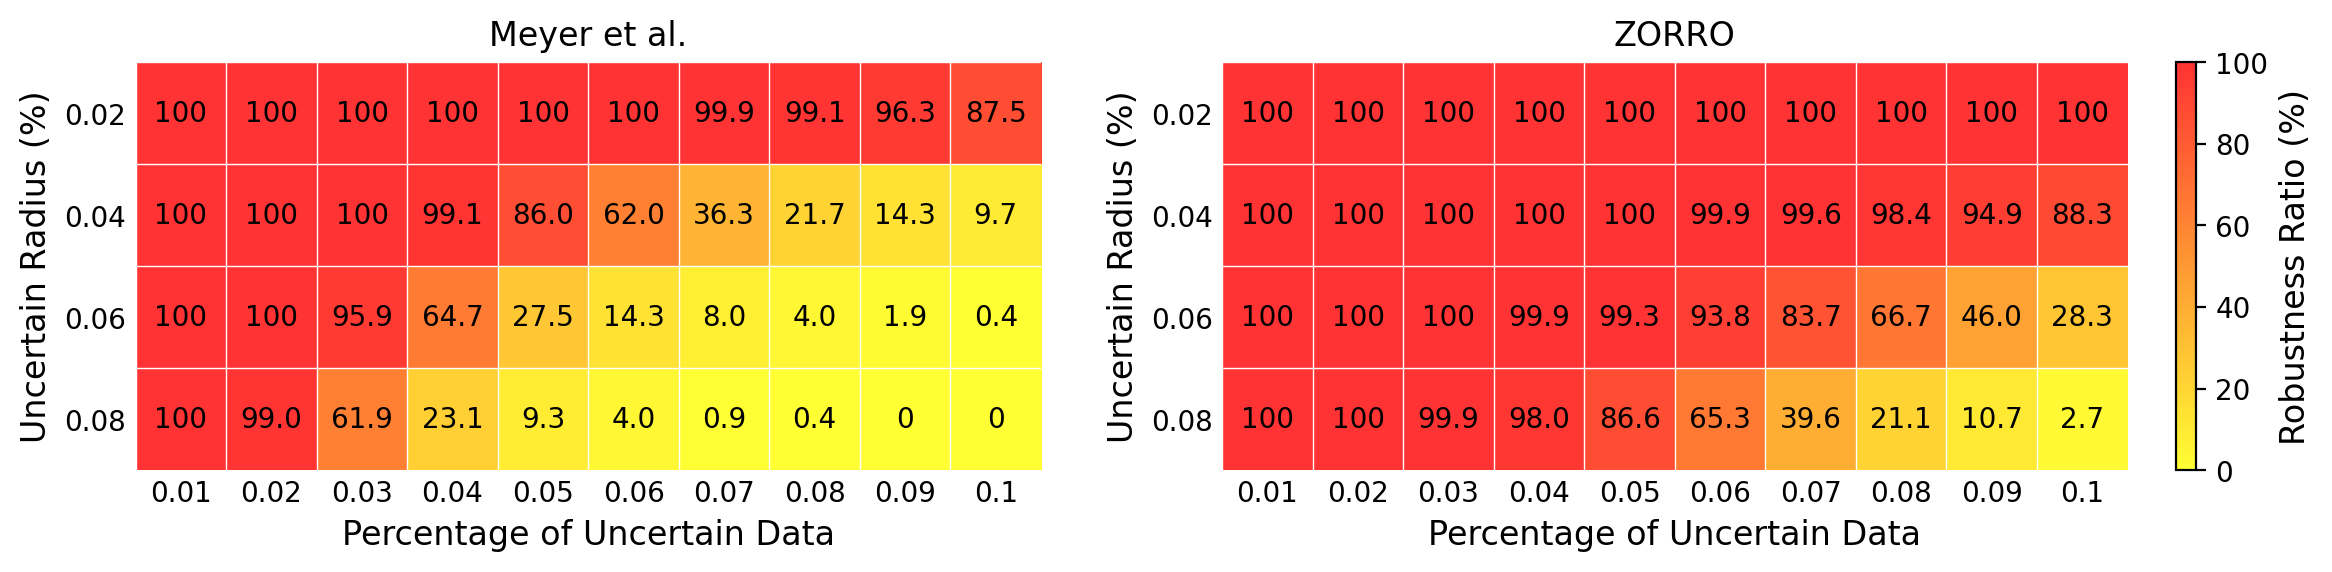

In [18]:
# Heatmaps
df = robustness_interval_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.02, 0.04, 0.06, 0.08]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zonotope_mean

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('graph_outs/insurance_naive.pdf', bbox_inches='tight')

## Naive Median Testing Results:

In [6]:
robustness_dicts = []
for seed in tqdm(range(10), desc=f'Progress'):
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict = dict()
    robustness_dict['uncertain_radius'] = uncertain_radiuses
    robustness_dict['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=False, seed=seed)
            robustness_dict[uncertain_pct].append(robustness_ratio)
    robustness_dicts.append(robustness_dict)

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 6:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 7:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 8:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 9:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 10:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

In [7]:
robustness_dicts_interval = []
for seed in tqdm(range(10), desc=f'Progress'):
    # mpg +- 2 is robust
    robustness_radius = 500
    label_range = (y_train.max()-y_train.min())
    ratios = [0.02, 0.04, 0.06, 0.08]
    uncertain_radiuses = [ratio*label_range for ratio in ratios]
    uncertain_pcts = list(np.arange(1, 11)/100)
    robustness_dict_interval = dict()
    robustness_dict_interval['uncertain_radius'] = uncertain_radiuses
    robustness_dict_interval['uncertain_radius_ratios'] = ratios
    for uncertain_pct in tqdm(uncertain_pcts, desc=f'Rep {seed+1}', leave=False):
        robustness_dict_interval[uncertain_pct] = list()
        uncertain_num = int(uncertain_pct*len(y_train))
        for uncertain_radius in tqdm(uncertain_radiuses, desc=f'Varying Uncertain Radius', leave=False):
            robustness_ratio = compute_robustness_ratio_label_error(X_train, y_train, X_test, y_test, 
                                                                    uncertain_num=uncertain_num, 
                                                                    uncertain_radius=uncertain_radius, 
                                                                    robustness_radius=robustness_radius, 
                                                                    interval=True, seed=seed)
            robustness_dict_interval[uncertain_pct].append(robustness_ratio)
    robustness_dicts_interval.append(robustness_dict_interval)

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Rep 1:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 2:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 3:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 4:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 5:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 6:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 7:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 8:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 9:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Rep 10:   0%|          | 0/10 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

Varying Uncertain Radius:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
robustness_meyer_frames = [pd.DataFrame(robustness_dicts_interval[i]).iloc[:, 2:] for i in range(10)]
robustness_zorro_frames = [pd.DataFrame(robustness_dicts[i]).iloc[:, 2:] for i in range(10)]

In [9]:
robustness_meyer_median = pd.concat(robustness_meyer_frames, axis=0).groupby(level=0).median()
robustness_zorro_median = pd.concat(robustness_zorro_frames, axis=0).groupby(level=0).median()

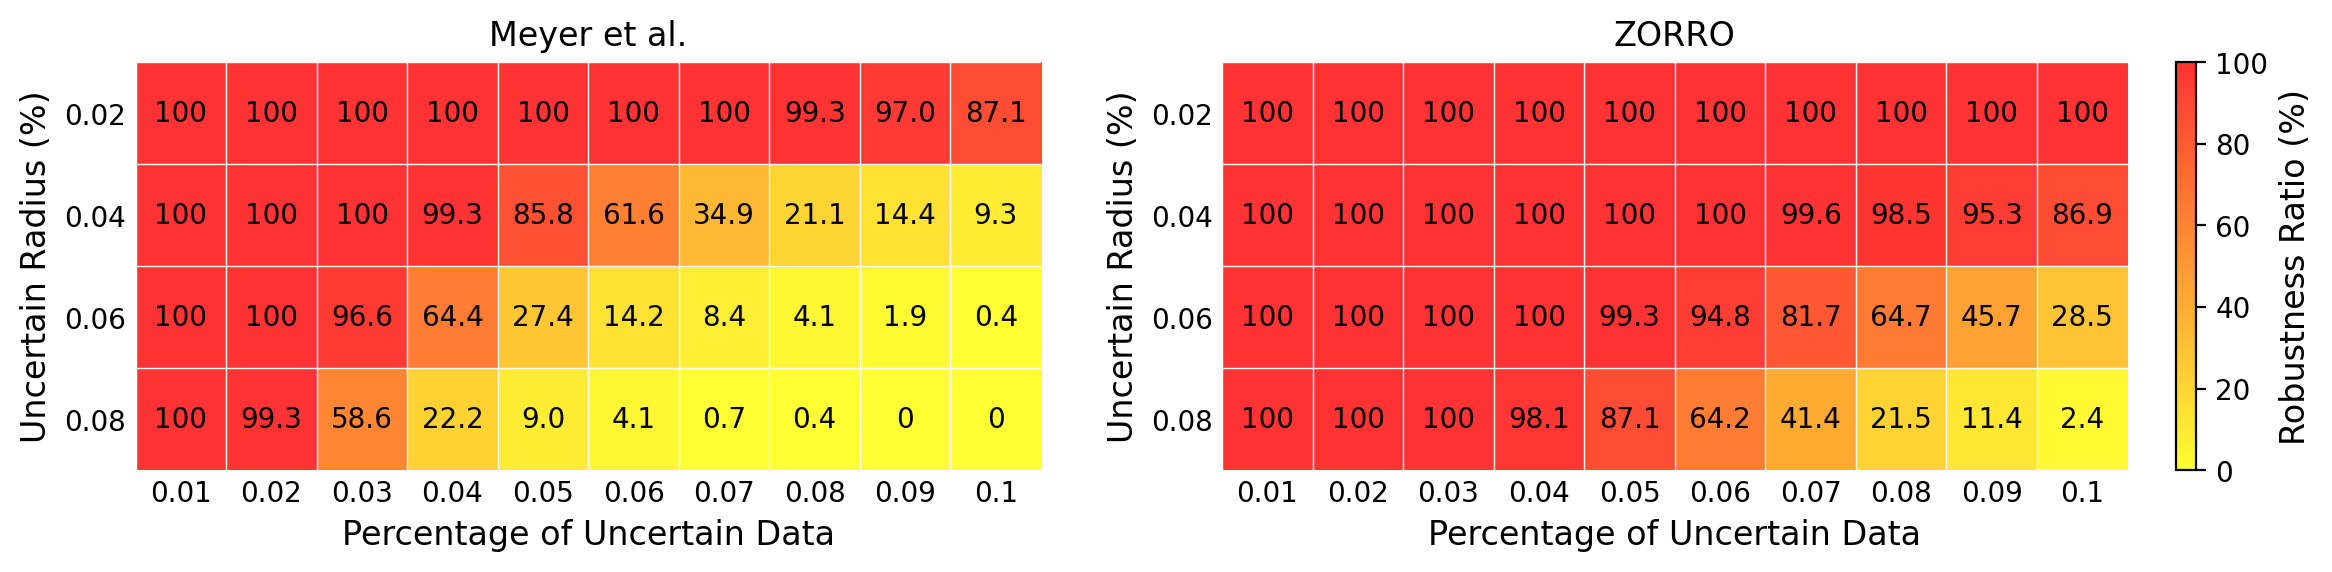

In [10]:
# Heatmaps
df = robustness_meyer_median

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages

# Labels for x-axis and y-axis
x_labels = df.columns.tolist()
y_labels = [0.02, 0.04, 0.06, 0.08]

# Create the heatmap plot
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True, dpi=200)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), dpi=200)
# cmap = plt.get_cmap("coolwarm")
cmap = plt.get_cmap("autumn_r")
heatmap = ax1.imshow(heatmap_data, cmap=cmap, interpolation='nearest', aspect='auto', 
                     alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar = plt.colorbar(heatmap, ax=ax1)
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax1.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax1.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax1.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax1.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax1.set_xticks(np.arange(len(x_labels)))
ax1.set_yticks(np.arange(len(y_labels)))
ax1.set_xticklabels(x_labels)
ax1.set_yticklabels(y_labels)
ax1.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set axis labels
ax1.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax1.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.0f}', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax1.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax1.text(j, i, f'{heatmap_data[i][j]:.1f}', ha='center', va='center', color='black')
ax1.set_title('Meyer et al.')

df = robustness_zorro_median

# Isolate the portion of the DataFrame for heatmap (exclude the first two columns)
heatmap_data = df.multiply(100).values  # Convert fractions to percentages
heatmap2 = ax2.imshow(heatmap_data, cmap=cmap, interpolation='nearest', 
                      aspect='auto', alpha=0.8, vmin=0, vmax=100)

# Add color bar
# cbar.set_label('% Percentage')

# Add white lines by adjusting the linewidth for minor ticks to create separation
ax2.set_xticks(np.arange(len(x_labels)) - 0.5, minor=True)
ax2.set_yticks(np.arange(len(y_labels)) - 0.5, minor=True)
ax2.grid(which="minor", color="white", linestyle='-', linewidth=0.5)
ax2.tick_params(which="minor", size=0)

# Set major ticks for labels without ticks
ax2.set_xticks(np.arange(len(x_labels)))
ax2.set_yticks(np.arange(len(y_labels)))
ax2.set_xticklabels(x_labels)
ax2.set_yticklabels(y_labels)
ax2.tick_params(axis='both', which='both', length=0)  # Remove tick marks

# Remove external boundaries
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Set axis labels
ax2.set_xlabel('Percentage of Uncertain Data', fontsize=12)
ax2.set_ylabel('Uncertain Radius (%)', fontsize=12)

# Add text annotations
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        if heatmap_data[i][j]==100:
            text = ax2.text(j, i, '100', ha='center', va='center', color='black')
        elif heatmap_data[i][j]==0:
            text = ax2.text(j, i, '0', ha='center', va='center', color='black')
        else:
            text = ax2.text(j, i, f'{np.around(heatmap_data[i][j], 1)}', ha='center', 
                            va='center', color='black')
ax2.set_title('ZORRO')

# fig.suptitle('Robustness Ratio (%)', fontsize=14)
plt.subplots_adjust(wspace=0.2, bottom=0.2, left=0.1, right=0.9)
cb = fig.colorbar(heatmap2, ax=(ax1, ax2), orientation='vertical', pad=0.02)
cb.set_label('Robustness Ratio (%)', fontsize=12)
plt.savefig('graph_outs/insurance_median_testing_naive.pdf', bbox_inches='tight')

In [11]:
len(X_train)

1070

In [13]:
len(X_test)

268